In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from fcmeans import FCM
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.metrics import adapted_rand_error, variation_of_information

import warnings
warnings.filterwarnings('ignore')

In [2]:
def metrics(img, res):
    err, prec, rec = adapted_rand_error(img, res)
    spl, mer = variation_of_information(img, res)
    print(f'Adapted Rand error: {err:.3f}')
    print(f'Adapted Rand precision: {prec:.3f}')
    print(f'Adapted Rand recall: {rec:.3f}')
    print(f'False splits: {spl:.3f}')
    print(f'False merges: {mer:.3f}')

In [3]:
def plot_kmeans(img, clusters):
    vectorized = img.reshape((-1,3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = clusters
    attempts = 10
    ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(result_image)
    plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
    plt.show()
    metrics(img, result_image)

def plot_gaussmix(img, k):
    vectorized = img.reshape((-1,3))
    vectorized = np.float32(vectorized)
    model = GaussianMixture(n_components=k,covariance_type='tied').fit(vectorized)
    Label=model.predict(vectorized)
    or_shape=img.shape
    segmented=Label.reshape(or_shape[0],or_shape[1])
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),
    plt.imshow(segmented)
    plt.title('Segmented Image when K = %i' % k), plt.xticks([]), plt.yticks([])
    plt.show()
    metrics(img[:,:,1], segmented)

def plot_fcm(img, K):   
    vectorized = img.reshape((-1,3))
    vectorized = np.float32(vectorized)
    cmeans = FCM(n_clusters=K)
    cmeans.fit(vectorized)
    centers = np.uint8(cmeans.centers)
    res = centers[cmeans.predict(vectorized).flatten()]
    result_image = res.reshape((img.shape))
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(result_image)
    plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
    plt.show()
    metrics(img, result_image)

def plot_aggclus(img, K):
    connectivity = grid_to_graph(*img.shape)
    vectorized = img.reshape((-1,1))
    ward = AgglomerativeClustering(n_clusters=K,
        linkage='ward', connectivity=connectivity).fit(vectorized)
    label = np.reshape(ward.labels_, img.shape)
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,2)
    plt.imshow(img, cmap=plt.cm.gray)
    for l in range(K):
        plt.contour(label == l, contours=1,
                colors=[plt.cm.nipy_spectral(l / float(K)), ])
    plt.title('Segmented Image when K = %i' % K)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    metrics(img, label)
    
def plot_meanshift(img):
    vectorized = img.reshape((-1,3))
    vectorized = np.float32(vectorized)
    bandwidth = estimate_bandwidth(vectorized, quantile=.06, n_samples=3000)
    ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
    ms.fit(vectorized)
    labeled=ms.labels_
    segments = np.unique(labeled)
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    for i, label in enumerate(labeled):
        total[label] = total[label] + vectorized[i]
        count[label] += 1
    avg = total/count
    avg = np.uint8(avg)
    res = avg[labeled]
    result = res.reshape((img.shape))
    plt.figure(figsize=(15, 15))
    plt.imshow(result)
    plt.title('Segmented Image when K = %i' % segments.shape[0])
    plt.show()
    metrics(img, result)
    
def plot_watershed(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    distance = ndi.distance_transform_edt(thresh)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=img)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Overlapping objects')
    ax[1].imshow(labels, cmap=plt.cm.nipy_spectral)
    ax[1].set_title('Separated objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    metrics(img, labels)
    
def plot_floodfill(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    M, N = img.shape
    otsu_threshold, image_result = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    n_objects = 0
    for i in range(M):
        for j in range(N):
            if img[i, j] >= otsu_threshold:
                n_objects += 1
                cv2.floodFill(img, None, (j, i), n_objects)
    for i in range(M):
        for j in [0, N-1]:
            if img[i, j] >= otsu_threshold:
                cv2.floodFill(img, None, (j, i), 0)
    for i in [0, M-1]:
        for j in range(N):
            if img[i, j] >= otsu_threshold:
                cv2.floodFill(img, None, (j, i), 0)
    plt.imshow(img),plt.show()
    metrics(img, image_result)
    
def plot_grabcut(img, image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    otsu_threshold, image_result = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    mask = image < otsu_threshold
    sel2 = np.zeros_like(image)
    sel2[mask] = image[mask]

    plt.imshow(sel2),plt.show()

    mask = np.zeros(sel2.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (0,0,img.shape[0],img.shape[1])
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==1)|(mask==3),0,1).astype('uint8')
    mask3 = np.where((mask==0)|(mask==2),0,1).astype('uint8')
    img1 = img*mask2[:,:,np.newaxis]
    img2 = img*mask3[:,:,np.newaxis]
    plt.imshow(img1),plt.colorbar(),plt.show(),plt.imshow(img2),plt.colorbar(),plt.show()
    metrics(img[:,:,1], image_result)
    
def rga(img, seedpoint, mask, tolerance):
    x, y = seedpoint[0], seedpoint[1]
    mask[x, y] = 1
    avg = np.mean(img[np.where(mask == 1)])
    if (y + 1 < img.shape[1] and mask[x, y + 1] == 0 and np.abs(avg - img[x, y + 1]) <= tolerance):
        rga(img, [x, y + 1], mask, tolerance)
    if (y - 1 >= 0 and mask[x, y - 1] == 0 and np.abs(avg - img[x, y - 1]) <= tolerance):
        rga(img, [x, y - 1], mask, tolerance)
    if (x + 1 < img.shape[0] and mask[x + 1, y] == 0 and np.abs(avg - img[x + 1, y]) <= tolerance):
        rga(img, [x + 1, y], mask, tolerance)
    if (x - 1 >= 0 and mask[x - 1, y] == 0 and np.abs(avg - img[x - 1, y]) <= tolerance):
        rga(img, [x - 1, y], mask, tolerance)
    return mask

def region_growing(img, gt, segm, seedpoint, tolerance):
    image = img
    mask = np.zeros(image.shape)
    res = rga(image, seedpoint, mask, tolerance).astype(int)
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(segm)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),
    plt.imshow(res)
    plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    metrics(img, res)

# Зображення №1

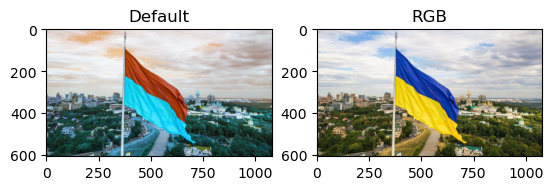

In [4]:
flag=cv2.imread('flag.webp')
rgb_flag = cv2.cvtColor(flag, cv2.COLOR_BGR2RGB)
plt.subplot(2,2,1)
plt.title('Default')
plt.imshow(flag)
plt.subplot(2,2,2)
plt.title('RGB')
plt.imshow(rgb_flag)

[[0 1 0]
 [1 1 1]
 [0 1 0]]


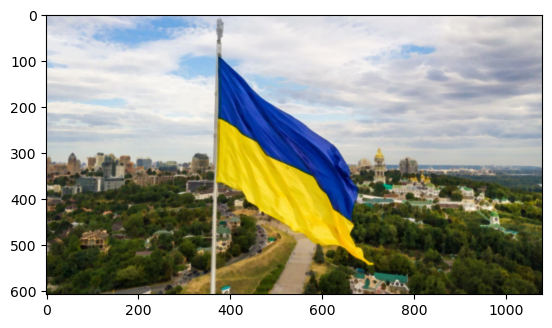

In [5]:
kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
print(kernel)

flag_blurred = cv2.GaussianBlur(rgb_flag, (3, 3), 0)

fig = cv2.erode(flag_blurred, kernel,iterations = 2)

plt.imshow(fig)
plt.show()  

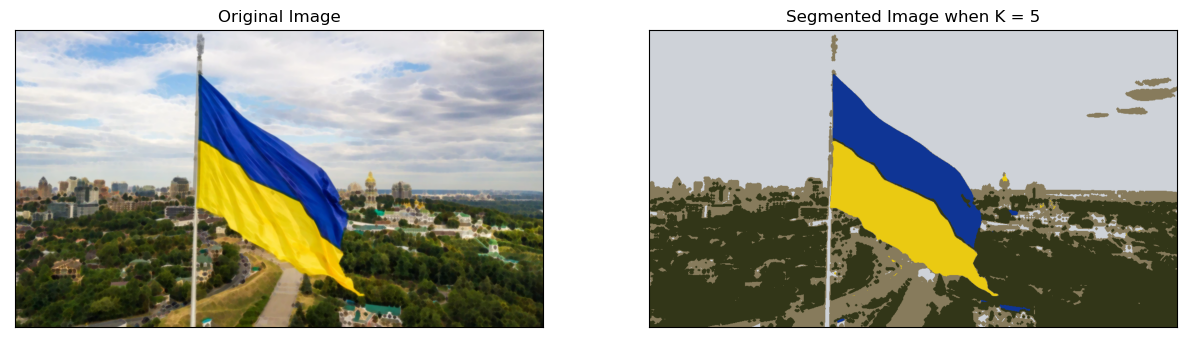

Adapted Rand error: 0.970
Adapted Rand precision: 0.315
Adapted Rand recall: 0.016
False splits: 1.974
False merges: 6.247


In [6]:
plot_kmeans(fig, 5)

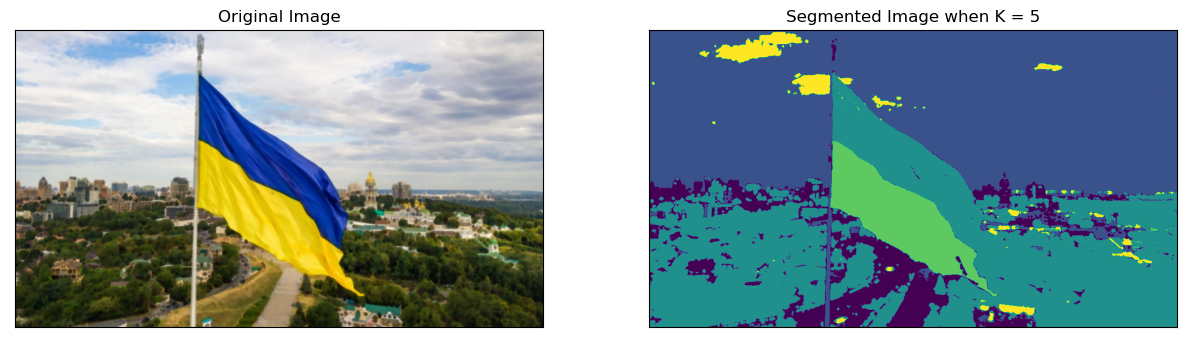

Adapted Rand error: 0.972
Adapted Rand precision: 0.819
Adapted Rand recall: 0.014
False splits: 0.531
False merges: 6.382


In [7]:
plot_gaussmix(fig, 5)

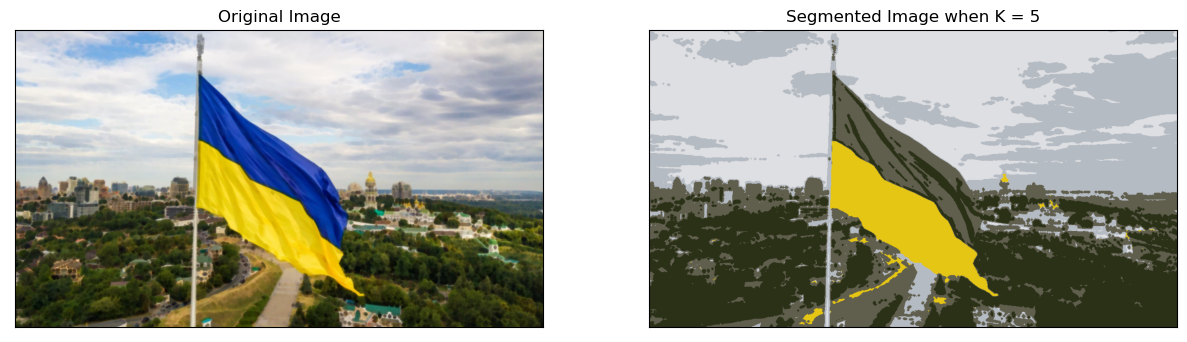

Adapted Rand error: 0.961
Adapted Rand precision: 0.286
Adapted Rand recall: 0.021
False splits: 2.084
False merges: 6.026


In [8]:
plot_fcm(fig, 5)

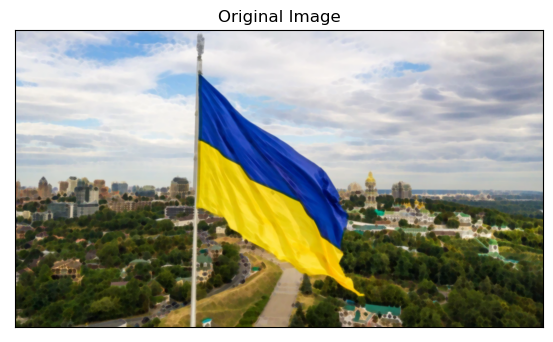

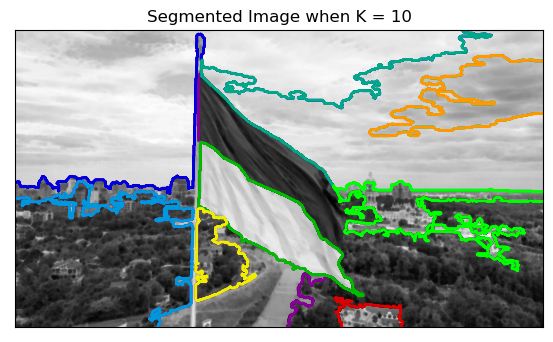

Adapted Rand error: 0.965
Adapted Rand precision: 0.486
Adapted Rand recall: 0.018
False splits: 1.464
False merges: 6.185


In [9]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1), plt.imshow(fig)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plot_aggclus(fig[:,:,1], 10)

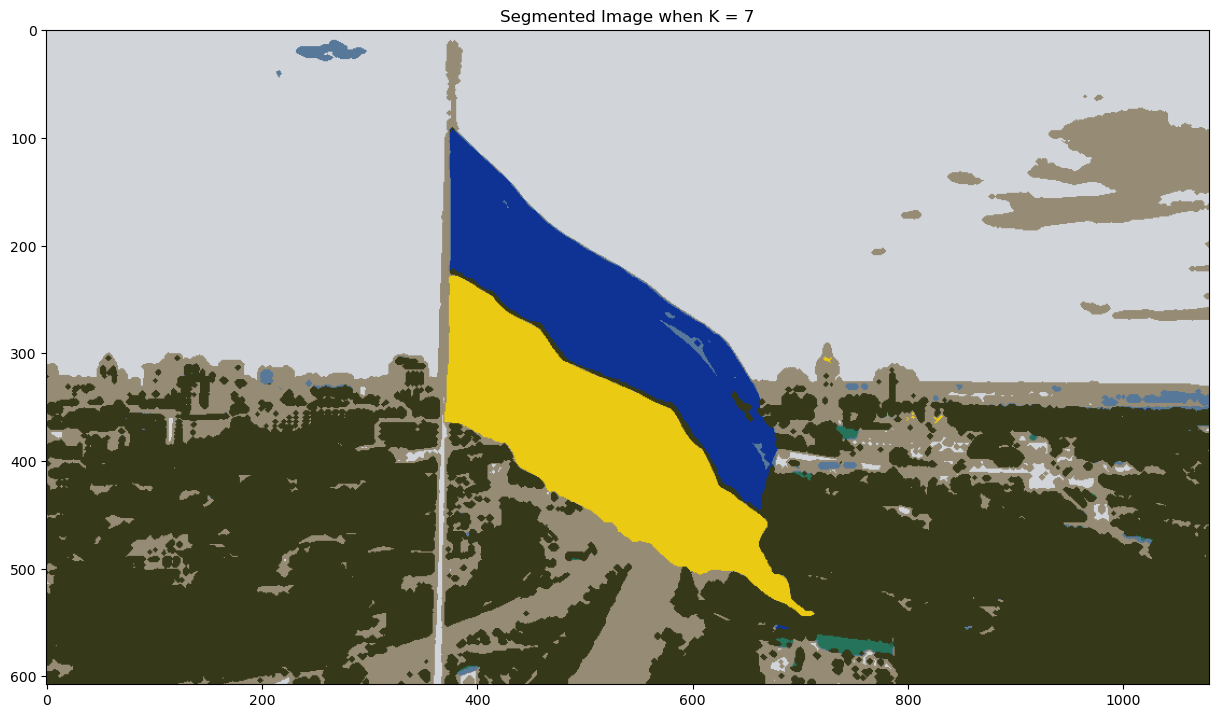

Adapted Rand error: 0.969
Adapted Rand precision: 0.314
Adapted Rand recall: 0.016
False splits: 2.003
False merges: 6.205


In [10]:
plot_meanshift(fig)

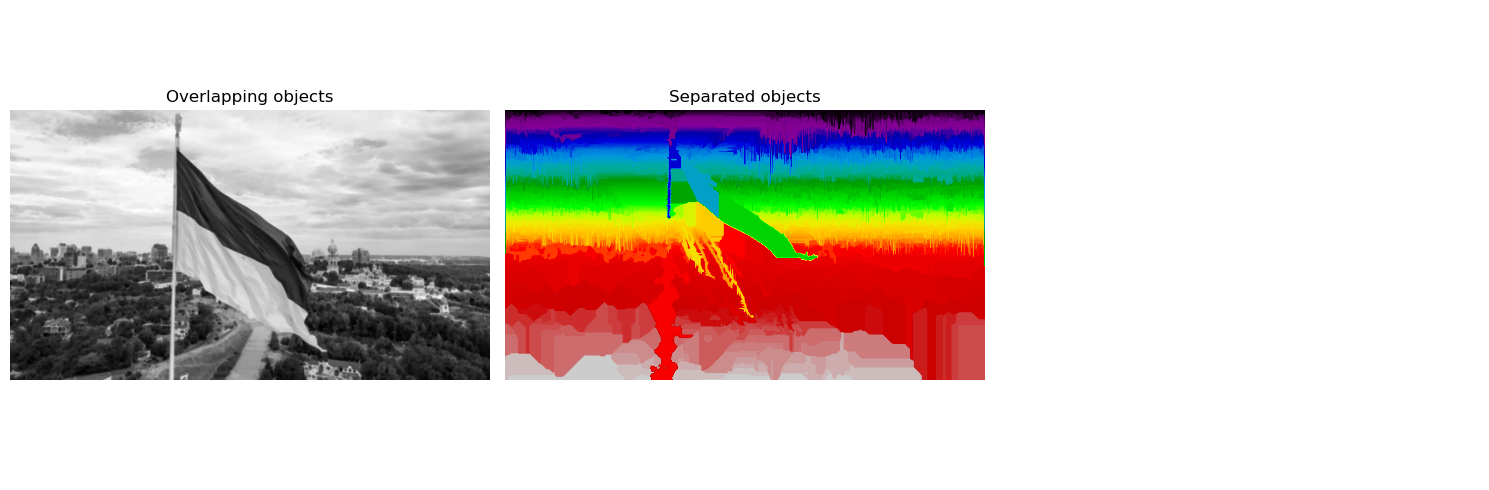

Adapted Rand error: 0.990
Adapted Rand precision: 0.007
Adapted Rand recall: 0.018
False splits: 8.272
False merges: 4.462


In [11]:
plot_watershed(fig)

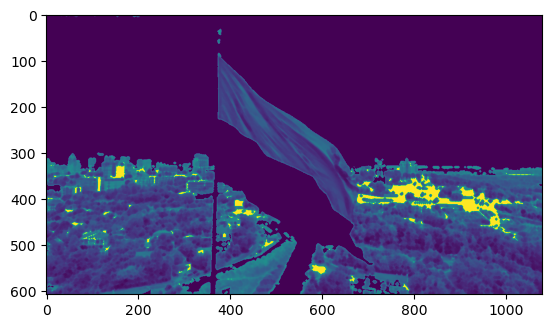

Adapted Rand error: 0.975
Adapted Rand precision: 0.991
Adapted Rand recall: 0.013
False splits: 0.020
False merges: 2.908


In [12]:
plot_floodfill(fig)

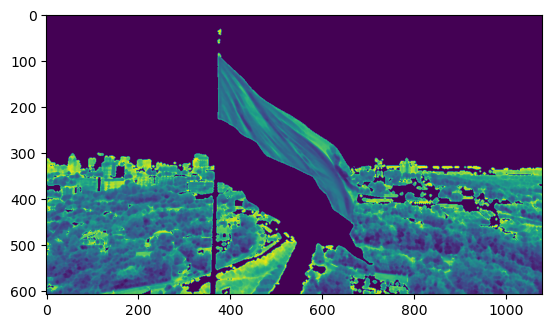

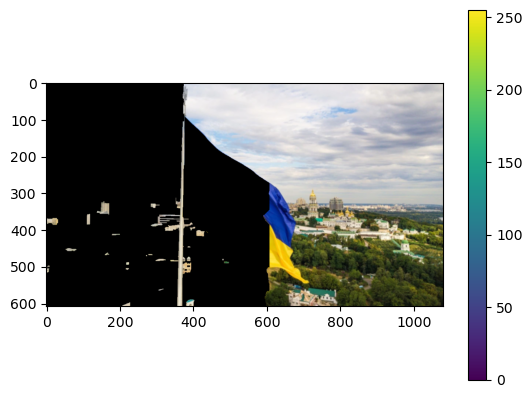

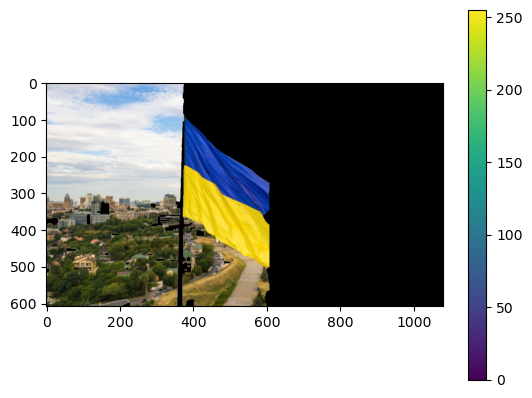

Adapted Rand error: 0.976
Adapted Rand precision: 0.974
Adapted Rand recall: 0.012
False splits: 0.124
False merges: 6.688


In [13]:
plot_grabcut(flag_blurred, fig)

In [14]:
flag_blurred = cv2.cvtColor(flag_blurred, cv2.COLOR_RGB2GRAY)
flag_masked = cv2.addWeighted(fig[:,:,1], 0.6, flag_blurred, 0.4, 1)
a, b, c = cv2.split(rgb_flag)
fig = b+c
fig = cv2.erode(fig, kernel,iterations = 2)

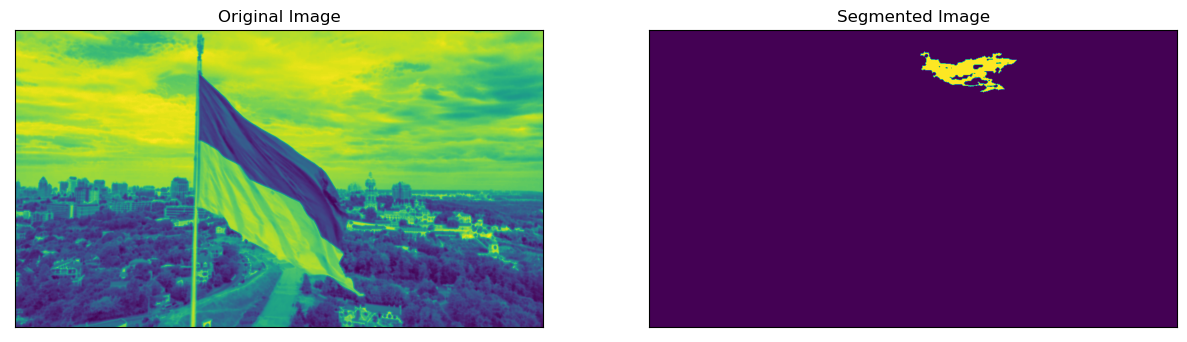

Adapted Rand error: 0.990
Adapted Rand precision: 0.989
Adapted Rand recall: 0.005
False splits: 0.028
False merges: 7.706


In [15]:
region_growing(fig, flag_blurred, flag_masked, seedpoint=(70, 700), tolerance=5)

In [16]:
import pandas as pd

In [17]:
are = [0.970, 0.972, 0.961, 0.965, 0.969, 0.990, 0.975, 0.976, 0.990]
arp = [0.315, 0.819, 0.286, 0.486, 0.314, 0.007, 0.991, 0.974, 0.989]
arr = [0.016, 0.014, 0.021, 0.018, 0.016, 0.018, 0.013, 0.012, 0.005]
fs = [1.974, 0.531, 2.084, 1.464, 2.003, 8.272, 0.020, 0.124, 0.028]
fm = [6.247, 6.382, 6.026, 6.185, 6.205, 4.462, 2.908, 6.688, 7.706]

results = pd.DataFrame({'Adapted Rand error': are,
                        'Adapted Rand precision': arp,
                        'Adapted Rand recall': arr,
                        'False splits': fs,
                       'False merges': fm},
                        index=['K-Means++','EM','Fuzzy K-Means','Agglomerative Clustering',
                              'Mean Shift','Watershed','Flood fill','Grab cut','Region Growing'])  
results

Adapted Rand error  Adapted Rand precision  \
K-Means++                              0.970                   0.315   
EM                                     0.972                   0.819   
Fuzzy K-Means                          0.961                   0.286   
Agglomerative Clustering               0.965                   0.486   
Mean Shift                             0.969                   0.314   
Watershed                              0.990                   0.007   
Flood fill                             0.975                   0.991   
Grab cut                               0.976                   0.974   
Region Growing                         0.990                   0.989   

                          Adapted Rand recall  False splits  False merges  
K-Means++                               0.016         1.974         6.247  
EM                                      0.014         0.531         6.382  
Fuzzy K-Means                           0.021         2.084         6.026  
Agglomerative Clustering                0.018         1.464         6.185  
Mean Shift                              0.016         2.003         6.205  
Watershed                               0.018         8.272         4.462  
Flood fill                              0.013         0.020         2.908  
Grab cut                                0.012         0.124         6.688  
Region Growing                          0.005         0.028         7.706

# Зображення №2

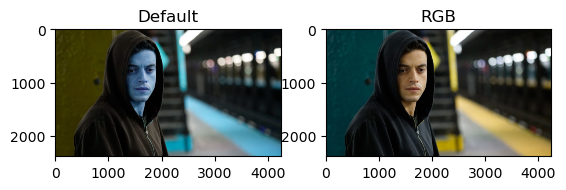

In [24]:
elliot=cv2.imread('mr-robot.webp')
rgb_elliot = cv2.cvtColor(elliot, cv2.COLOR_BGR2RGB)
plt.subplot(2,2,1)
plt.title('Default')
plt.imshow(elliot)
plt.subplot(2,2,2)
plt.title('RGB')
plt.imshow(rgb_elliot)

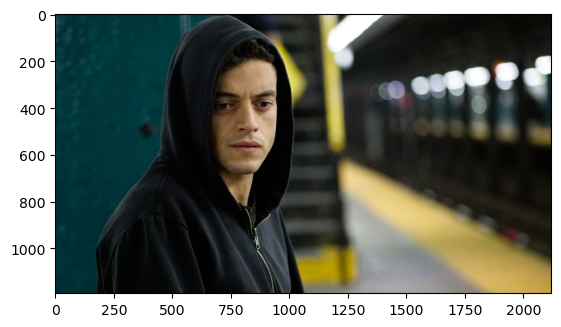

In [26]:
rows, cols, dot = map(int, elliot.shape)

rgb_elliot = cv2.pyrDown(rgb_elliot, dstsize=(cols // 2, rows // 2))
plt.imshow(rgb_elliot)
plt.show()

[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]


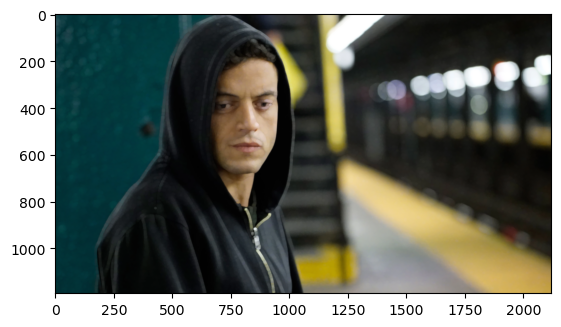

In [27]:
kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
print(kernel)

elliot_blurred = cv2.GaussianBlur(rgb_elliot, (5, 5), 0)

fig = cv2.dilate(elliot_blurred, kernel,iterations = 2)

plt.imshow(fig)
plt.show()

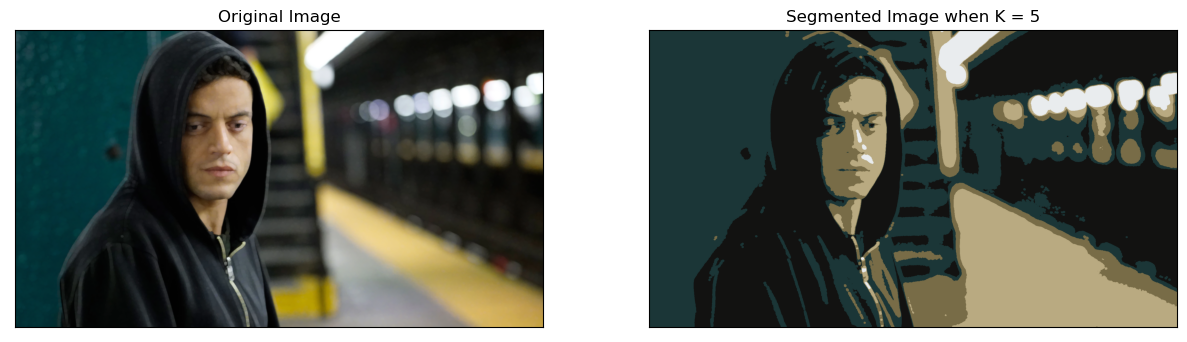

Adapted Rand error: 0.935
Adapted Rand precision: 0.425
Adapted Rand recall: 0.035
False splits: 1.653
False merges: 5.574


In [28]:
plot_kmeans(fig, 5)

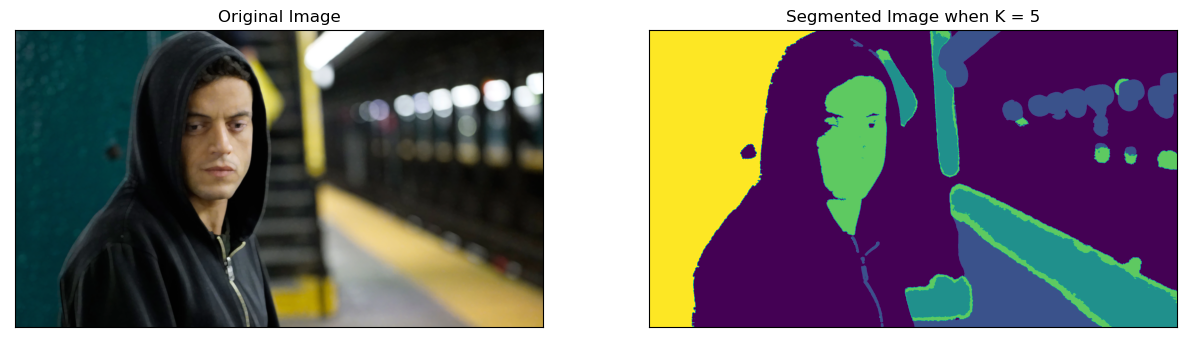

Adapted Rand error: 0.965
Adapted Rand precision: 0.766
Adapted Rand recall: 0.018
False splits: 0.688
False merges: 6.150


In [29]:
plot_gaussmix(fig, 5)

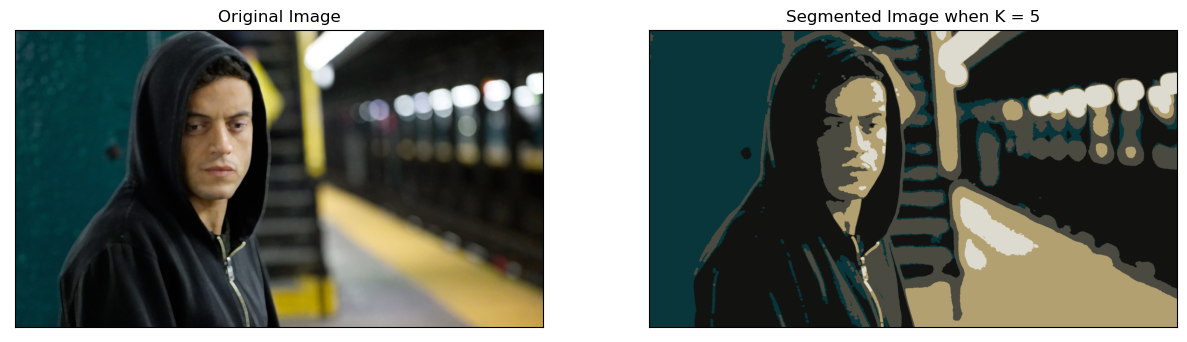

Adapted Rand error: 0.931
Adapted Rand precision: 0.324
Adapted Rand recall: 0.038
False splits: 1.988
False merges: 5.540


In [30]:
plot_fcm(fig, 5)

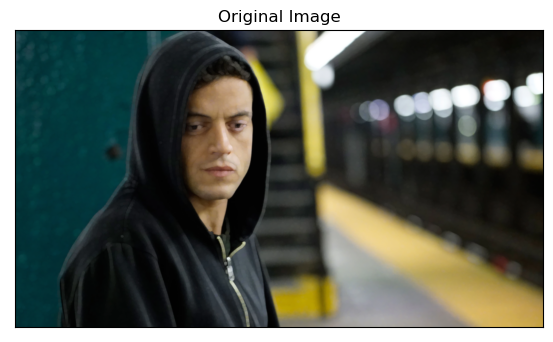

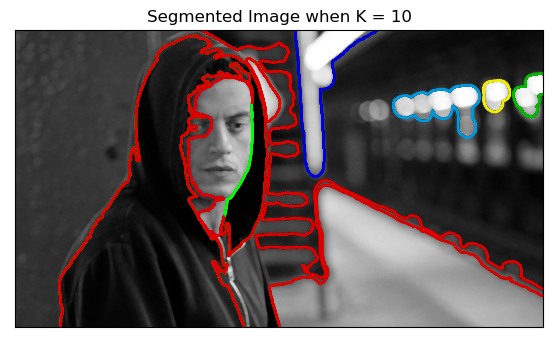

Adapted Rand error: 0.952
Adapted Rand precision: 0.638
Adapted Rand recall: 0.025
False splits: 1.117
False merges: 5.976


In [31]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1), plt.imshow(fig)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plot_aggclus(fig[:,:,1], 10)

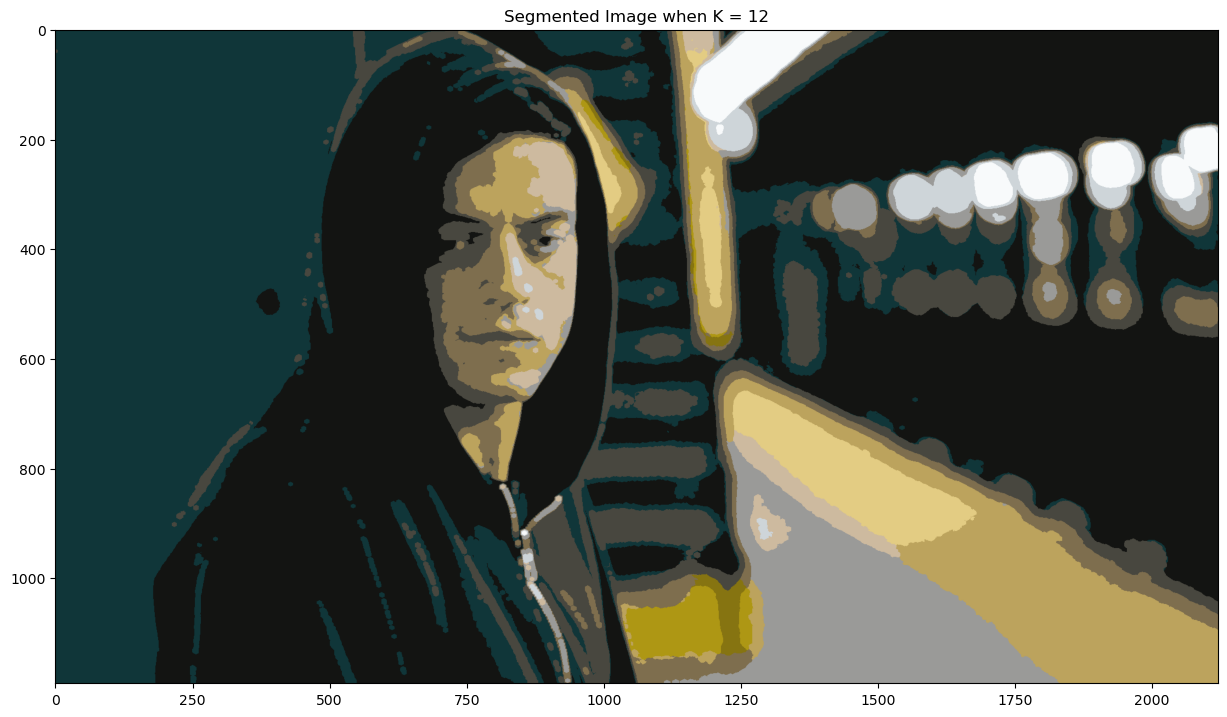

Adapted Rand error: 0.926
Adapted Rand precision: 0.331
Adapted Rand recall: 0.042
False splits: 2.120
False merges: 5.272


In [32]:
plot_meanshift(fig)

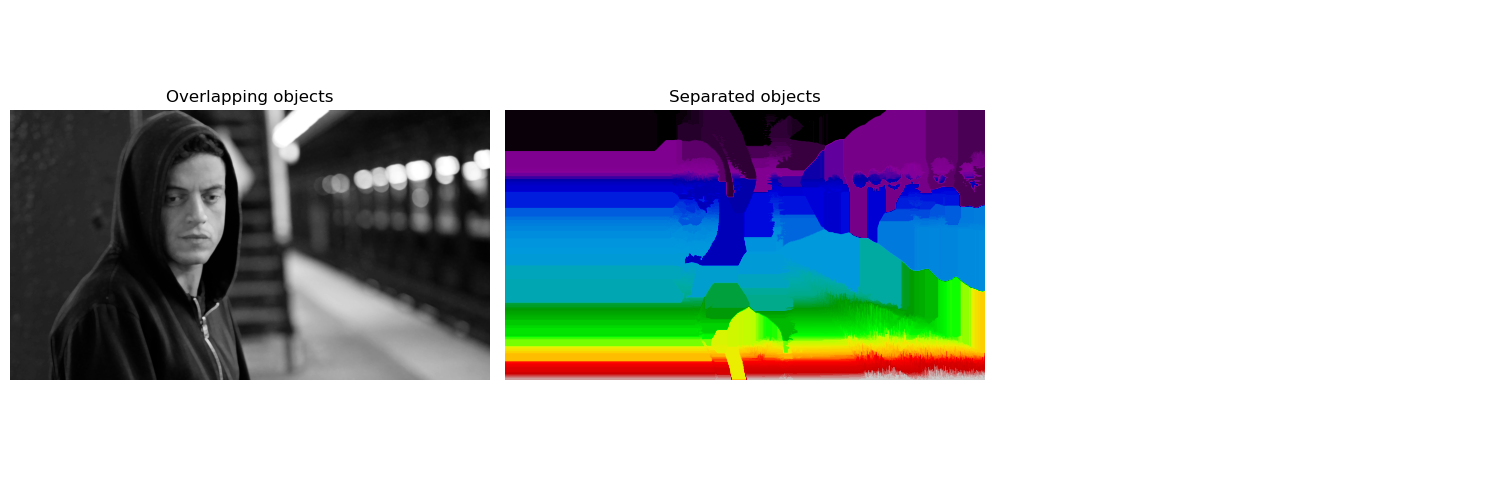

Adapted Rand error: 0.955
Adapted Rand precision: 0.048
Adapted Rand recall: 0.043
False splits: 6.588
False merges: 4.948


In [33]:
plot_watershed(fig)

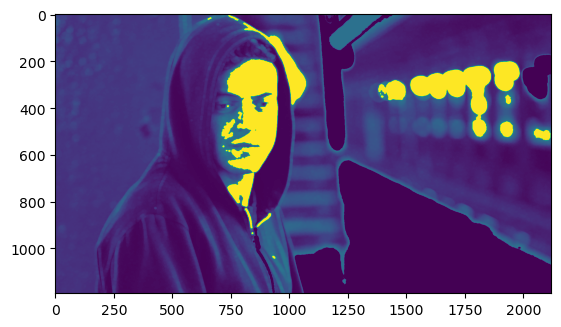

Adapted Rand error: 0.954
Adapted Rand precision: 0.988
Adapted Rand recall: 0.024
False splits: 0.022
False merges: 4.988


In [34]:
plot_floodfill(fig)

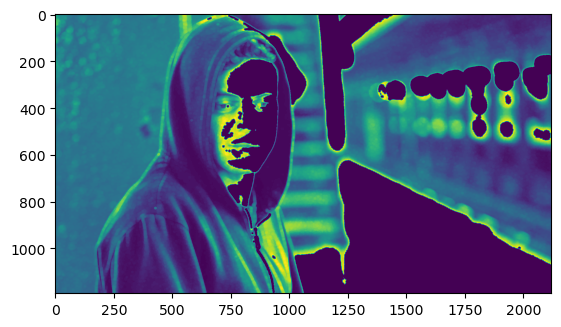

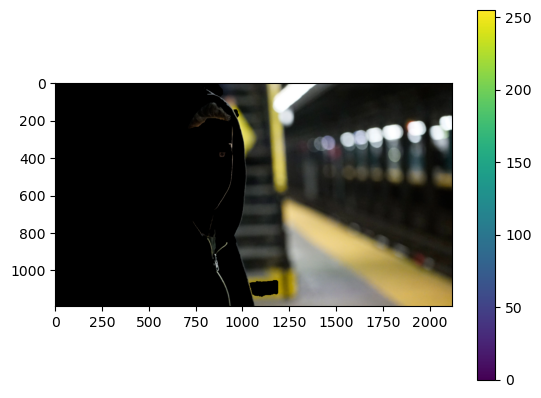

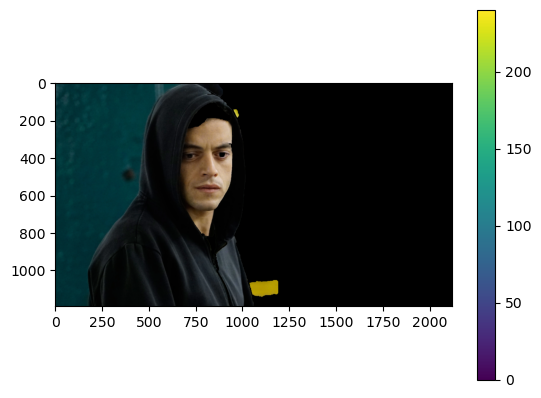

Adapted Rand error: 0.971
Adapted Rand precision: 0.987
Adapted Rand recall: 0.015
False splits: 0.075
False merges: 6.469


In [35]:
plot_grabcut(elliot_blurred, fig)

In [38]:
elliot_masked = cv2.addWeighted(fig[:,:,1], 0.6, elliot_blurred, 0.4, 1)
a, b, c = cv2.split(rgb_elliot)
fig = b+c
fig = cv2.erode(fig, kernel,iterations = 2)

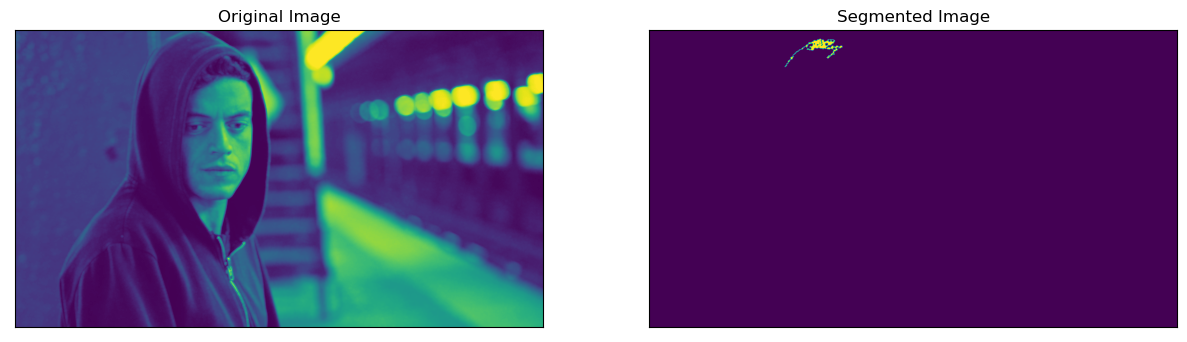

Adapted Rand error: 0.984
Adapted Rand precision: 0.998
Adapted Rand recall: 0.008
False splits: 0.010
False merges: 7.315


In [43]:
region_growing(fig, elliot_blurred, elliot_masked, seedpoint=(70, 700), tolerance=5)

In [45]:
are = [0.935, 0.965, 0.931, 0.952, 0.926, 0.955, 0.954, 0.971, 0.984]
arp = [0.425, 0.766, 0.324, 0.638, 0.331, 0.048, 0.988, 0.987, 0.998]
arr = [0.035, 0.018, 0.038, 0.025, 0.042, 0.043, 0.024, 0.015, 0.008]
fs = [1.653, 0.688, 1.988, 1.117, 2.120, 6.588, 0.022, 0.075, 0.010]
fm = [5.574, 6.150, 5.540, 5.976, 5.272, 4.948, 4.988, 6.469, 7.315]

results = pd.DataFrame({'Adapted Rand error': are,
                        'Adapted Rand precision': arp,
                        'Adapted Rand recall': arr,
                        'False splits': fs,
                       'False merges': fm},
                        index=['K-Means++','EM','Fuzzy K-Means','Agglomerative Clustering',
                              'Mean Shift','Watershed','Flood fill','Grab cut','Region Growing'])  
results

Adapted Rand error  Adapted Rand precision  \
K-Means++                              0.935                   0.425   
EM                                     0.965                   0.766   
Fuzzy K-Means                          0.931                   0.324   
Agglomerative Clustering               0.952                   0.638   
Mean Shift                             0.926                   0.331   
Watershed                              0.955                   0.048   
Flood fill                             0.954                   0.988   
Grab cut                               0.971                   0.987   
Region Growing                         0.984                   0.998   

                          Adapted Rand recall  False splits  False merges  
K-Means++                               0.035         1.653         5.574  
EM                                      0.018         0.688         6.150  
Fuzzy K-Means                           0.038         1.988         5.540  
Agglomerative Clustering                0.025         1.117         5.976  
Mean Shift                              0.042         2.120         5.272  
Watershed                               0.043         6.588         4.948  
Flood fill                              0.024         0.022         4.988  
Grab cut                                0.015         0.075         6.469  
Region Growing                          0.008         0.010         7.315

# Висновки

В даній лабораторній роботі було проведено порівняльний аналіз різних алгоритмів кластеризації для сегментації двох зображень з класичними методами.

Після виконнаня умов лабораторної роботи можна сказати, що найкращими методами для даних зображень виявились Flood fill та Fuzzy K-Means. Стосовно метрик кластеризації, на мою думку, краще оцінює результат variation_of_information. Ці показники в даному випадку не давали хибних уявлень про якість кластеризації на відміну від adapted_rand_error. Щодо попередньої обробки, то можна сказати, що вона допомогла змінити кольорові плями (для першого зображення використано ерозію зі згладжуванням, для другого диляцію зі згладжуванням). 